##### Copyright 2023 Melchor Lafuente Duque

# IMAGE TO AUDIO - IDCT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import scipy.io.wavfile as wavfile
import scipy.fftpack as sp
import scipy.signal as s
import cupy as cp
from PIL import Image
import imageio.v2 as imageio
import os
import cv2

## Functions to read and write wav files

In [2]:
def read_wav(file_name, dir_name_input = "INPUT"):
    file_location = join(dir_name_input, file_name + ".wav")
    sample_rate, signal = wavfile.read(file_location)
    
    # If the signal is stereo, we transform it to mono:
    if signal.ndim > 1:
        left_channel = signal[:, 0]
        right_channel = signal[:, 1]
        signal = np.mean([left_channel, right_channel], axis=0)   
        
    return sample_rate, signal

def write_wav(file_name, sr, signal, output_dir_name = "OUTPUT"):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    file_name_output = os.path.join(output_path, file_name + ".wav")
    wavfile.write(file_name_output, sr, signal.astype('int16'))

## SETUP

We define the GPU device that we are going to use, in my case, I have three devices that I could use. So I will use one that is not being used by the previous process, the number one for example:

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" #0,1,2,3

We define some other functions that we'll be using:

## Functions to plot signals and images

In [4]:
def plot_signal(sr, signal, file_name, file_suffix = "wav"):
    
    # Compute time axis in seconds
    time = np.arange(len(signal)) / float(sr)
    duration = time.max()

    # Plot audio signal
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(time, signal)
    
    # Add a title and axis labels
    file_location = join(file_name + "." + file_suffix)
    
    ax.set_title(file_location)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (A)")

    plt.show()

In [5]:
def plot_image(img, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [6]:
def plot_freq_array(freq_array):
    print("The image below has a dimension of: ", freq_array.T.shape)

    # Display the frequency domain image
    fig, ax = plt.subplots(figsize=(18, 3))
    ax.imshow(freq_array.T, aspect='auto', origin='lower')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Time (segment index)')
    fig.show()

## Functions to read images and their range of frequencies

In [7]:
def read_max_min(dir_name_input, signal_name = "ORIGINAL", max_filename = "max", min_filename = "min"):
    
    max_filename = signal_name + "_" + max_filename + ".txt"
    min_filename = signal_name + "_" + min_filename + ".txt"
    
    file_location_max = join(dir_name_input, max_filename)
    file_location_min = join(dir_name_input, min_filename)
    
    freq_max = np.loadtxt(file_location_max, dtype=np.float64)
    freq_min = np.loadtxt(file_location_min, dtype=np.float64)
    return freq_max, freq_min

In [8]:
def read_image(dir_name_input = "OUTPUT_2", filename = "image", img_suffix = "png"):
    img_filename = filename + "." + img_suffix
    file_location_img = join(dir_name_input, img_filename)
    
    return cv2.imread(file_location_img) #BGR 

# IMAGE TO AUDIO:

## Read Images

We'll work with the original image of color divided in 3 channels: Blue, Green, Red, as well as with the gray image obtained by combining these channels into a single one:

In [9]:
# Load image
image = read_image(filename = "final_image_combined") #BGR 

# Transform to grey scale
grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [10]:
image.shape, grey_image.shape

((662, 21837, 3), (662, 21837))

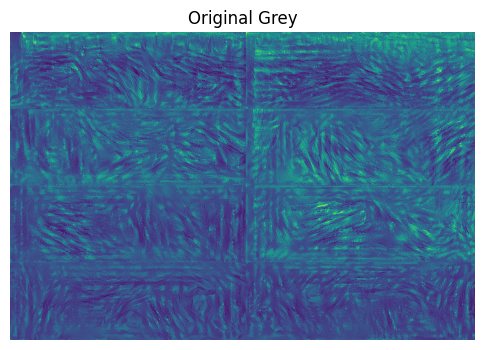

In [11]:
plot_image(grey_image[:,:1000], "Original Grey")

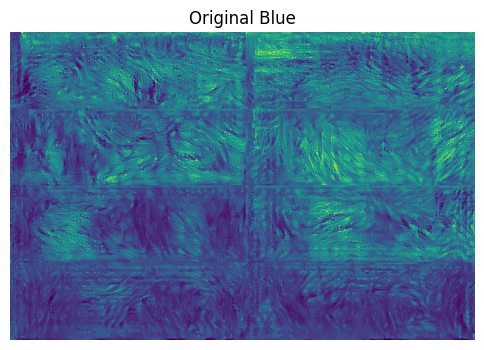

In [12]:
plot_image(image[:,:1000,0], "Original Blue")

## Blur function

As can be seen in the previous images, clearly delimited stripes appear in the places where the different slices of the previous process began and ended. To try to solve this noise we are going to use a blur function.

This function will generate a motion blur perpendicular to the horizontal axis.

In [13]:
def motion_blur(image, size=15, direction = -5):
    # Apply motion blur from top to bottom
    kernel = np.zeros((size, size))
    kernel[:, int((size - 1) / 2)] = np.ones(size) / size

    # Apply motion blur to the blue channel of the image
    channel_0 = image[:, :, 0]
    blurred_ch0 = cv2.filter2D(channel_0, direction, kernel)
    
    # Apply motion blur to the green channel of the image
    channel_1 = image[:, :, 1]
    blurred_ch1 = cv2.filter2D(channel_1, direction, kernel)
    
    # Apply motion blur to the red channel of the image
    channel_2 = image[:, :, 2]
    blurred_ch2 = cv2.filter2D(channel_2, direction, kernel)

    # Merge the original color channels into a single image
    blurred_image = np.copy(image)
    blurred_image[:, :, 0] = blurred_ch0
    blurred_image[:, :, 1] = blurred_ch1
    blurred_image[:, :, 2] = blurred_ch2

    return blurred_image

We can blur the images a bit:

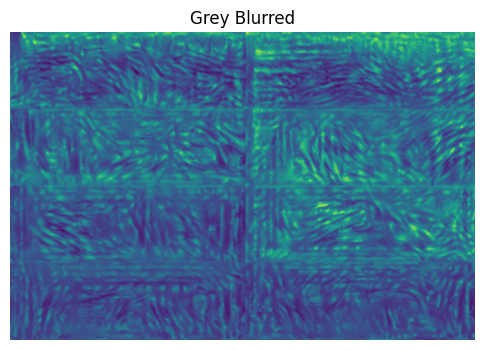

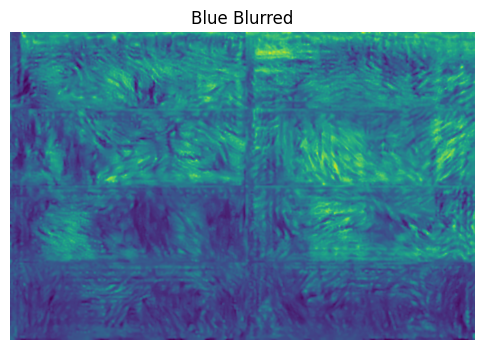

In [14]:
blurred_image = cv2.blur(image, (5, 5))
blurred_image_GREY = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY)

plot_image(blurred_image_GREY[:,:1000], "Grey Blurred")
plot_image(blurred_image[:,:1000, 0], "Blue Blurred")

Or we can blur them a lot making sure that the previous problem disappears completely:

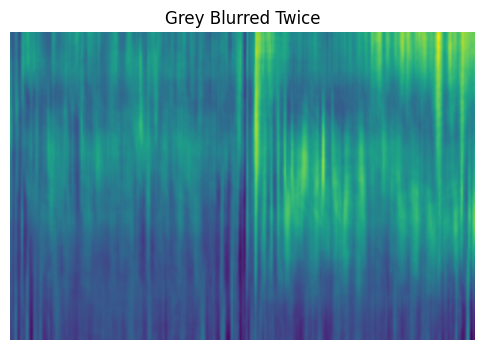

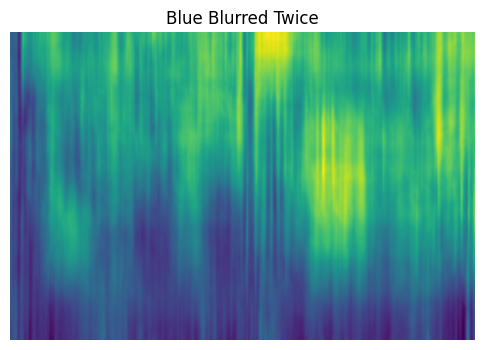

In [15]:
# Aplicar el desenfoque de movimiento hacia abajo
blurred_image_2 = motion_blur(blurred_image, size = 200)
blurred_image_2_GREY = cv2.cvtColor(blurred_image_2, cv2.COLOR_BGR2GRAY)

plot_image(blurred_image_2_GREY[:,:1000], "Grey Blurred Twice")
plot_image(blurred_image_2[:,:1000,0], "Blue Blurred Twice")

## Returning the original range of values

Let's now return the range of these images to their original range, taking into account the maximum and minimum frequencies that the original song had since the beginning. We will work with the following images:

* Grey image
* Grey image (a bit blurry)
* Grey image (very blurry)
* Blue image
* Blue image (very blurry)
* Green image
* Green image (very blurry)
* Red image
* Red image (very blurry)

## GREY

The image below has a dimension of:  (662, 21837)


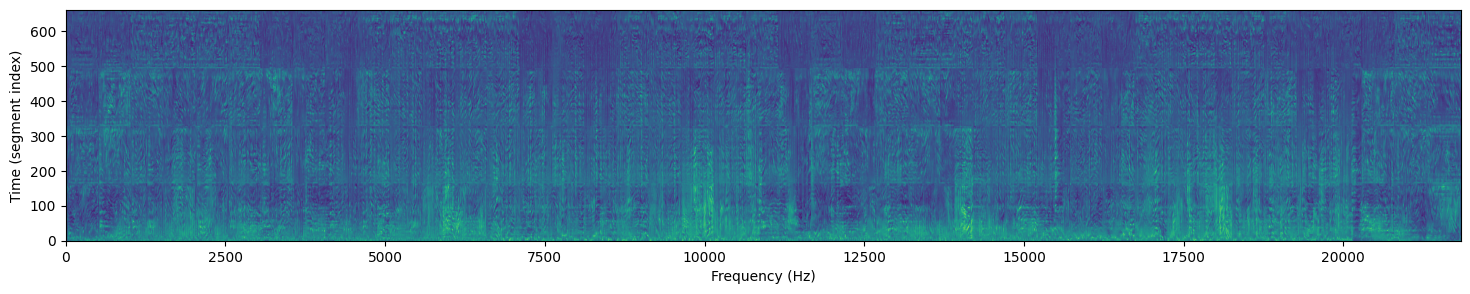

In [16]:
# read the image as a numpy array
img_float64 = np.asarray(grey_image).astype("float64")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_1", signal_name = "ORIGINAL")

# return the original values
img_reconstructed_GREY = ((freq_max - freq_min) * img_float64) + freq_min

# Display the frequency domain image
plot_freq_array(img_reconstructed_GREY.T)

The image below has a dimension of:  (662, 21837)


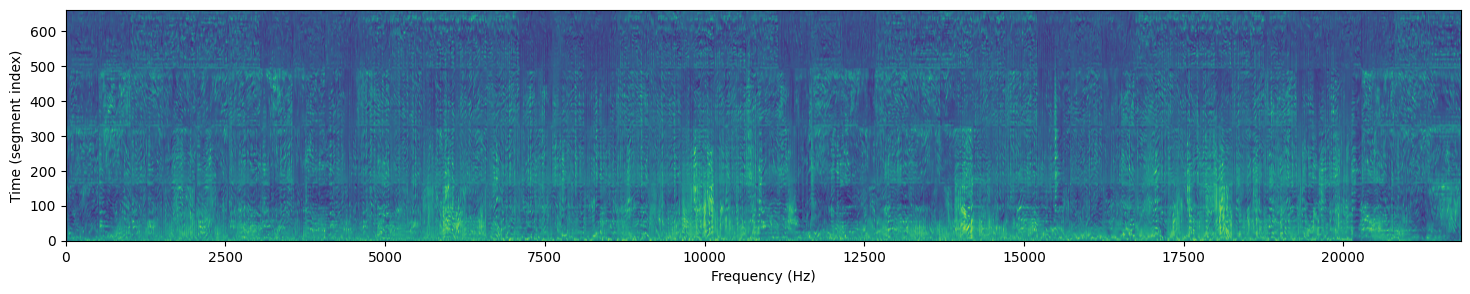

In [17]:
# read the image as a numpy array
img_float64 = np.asarray(blurred_image_GREY).astype("float64")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_1", signal_name = "ORIGINAL")

# return the original values
img_reconstructed_blurred_GREY = ((freq_max - freq_min) * img_float64) + freq_min

# Display the frequency domain image
plot_freq_array(img_reconstructed_blurred_GREY.T)

The image below has a dimension of:  (662, 21837)


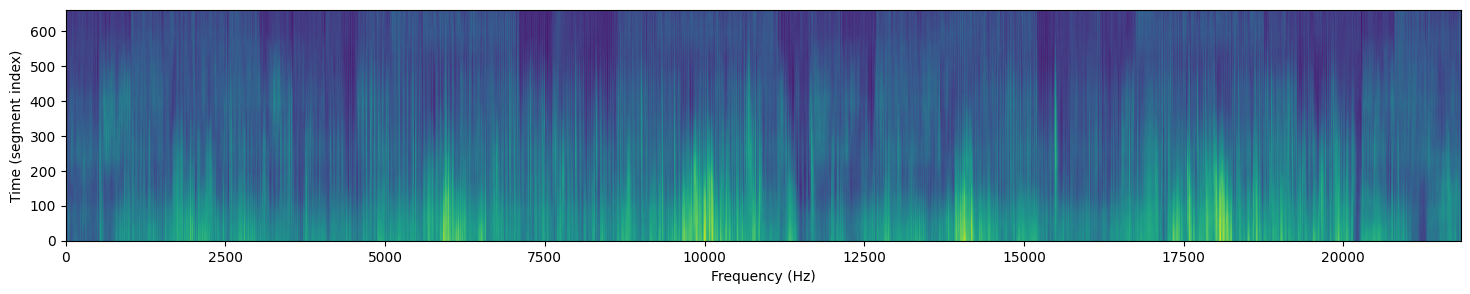

In [18]:
# read the image as a numpy array
img_float64 = np.asarray(blurred_image_2_GREY).astype("float64")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_1", signal_name = "ORIGINAL")

# return the original values
img_reconstructed_blurred_2_GREY = ((freq_max - freq_min) * img_float64) + freq_min

# Display the frequency domain image
plot_freq_array(img_reconstructed_blurred_2_GREY.T)

## BLUE

The image below has a dimension of:  (662, 21837)


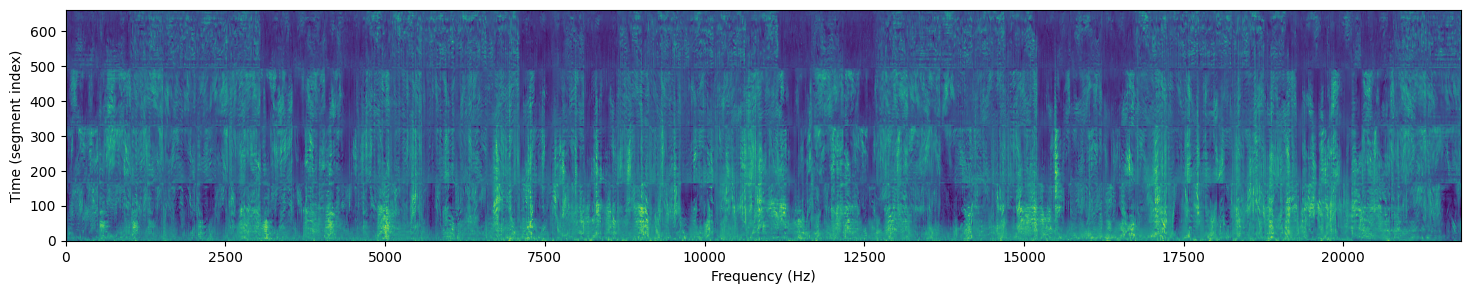

In [19]:
# read the image as a numpy array
img_float64 = np.asarray(image[:,:,0]).astype("float64")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_1", signal_name = "ORIGINAL")

# return the original values
img_reconstructed_B = ((freq_max - freq_min) * img_float64) + freq_min

# Display the frequency domain image
plot_freq_array(img_reconstructed_B.T)

The image below has a dimension of:  (662, 21837)


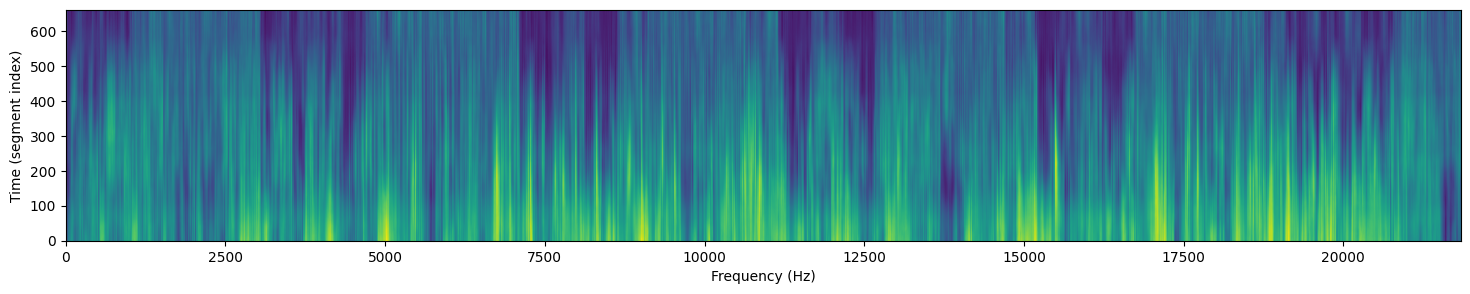

In [20]:
# read the image as a numpy array
img_float64 = np.asarray(blurred_image_2[:,:,0]).astype("float64")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_1", signal_name = "ORIGINAL")

# return the original values
img_reconstructed_blurred_B = ((freq_max - freq_min) * img_float64) + freq_min

# Display the frequency domain image
plot_freq_array(img_reconstructed_blurred_B.T)

## GREEN

The image below has a dimension of:  (662, 21837)


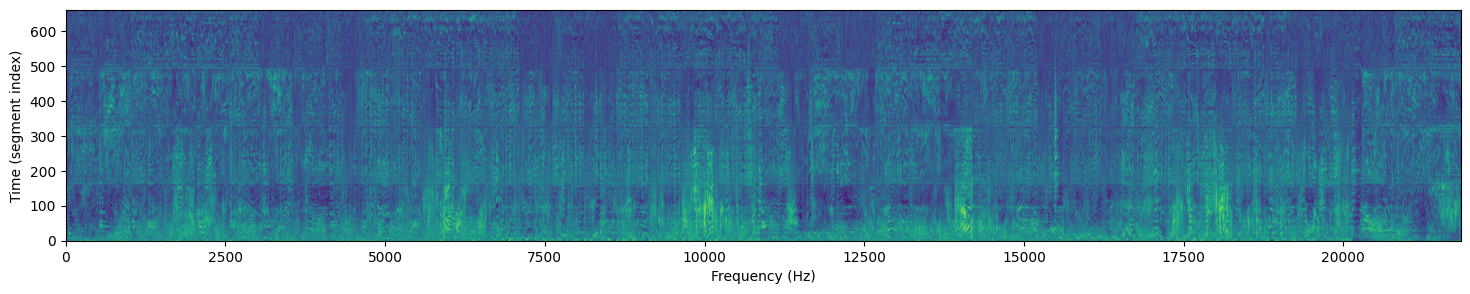

In [21]:
# read the image as a numpy array
img_float64 = np.asarray(image[:,:,1]).astype("float64")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_1", signal_name = "ORIGINAL")

# return the original values
img_reconstructed_G = ((freq_max - freq_min) * img_float64) + freq_min

# Display the frequency domain image
plot_freq_array(img_reconstructed_G.T)

The image below has a dimension of:  (662, 21837)


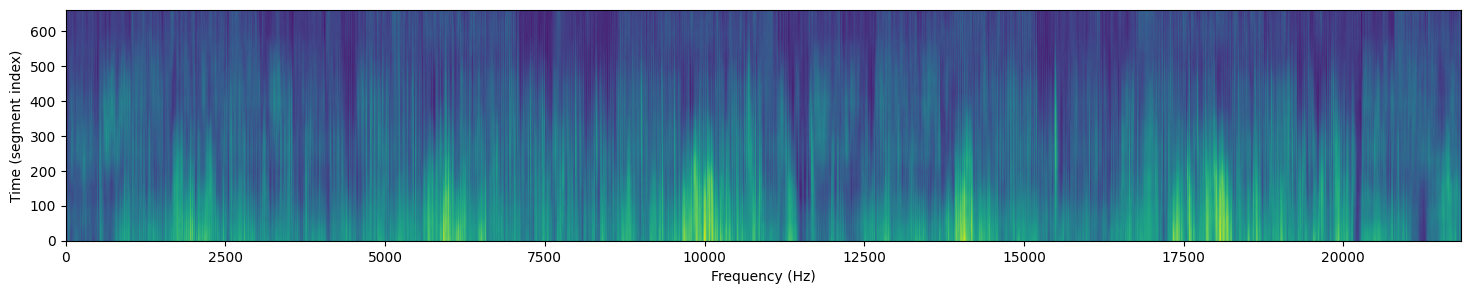

In [22]:
# read the image as a numpy array
img_float64 = np.asarray(blurred_image_2[:,:,1]).astype("float64")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_1", signal_name = "ORIGINAL")

# return the original values
img_reconstructed_blurred_G = ((freq_max - freq_min) * img_float64) + freq_min

# Display the frequency domain image
plot_freq_array(img_reconstructed_blurred_G.T)

## RED

The image below has a dimension of:  (662, 21837)


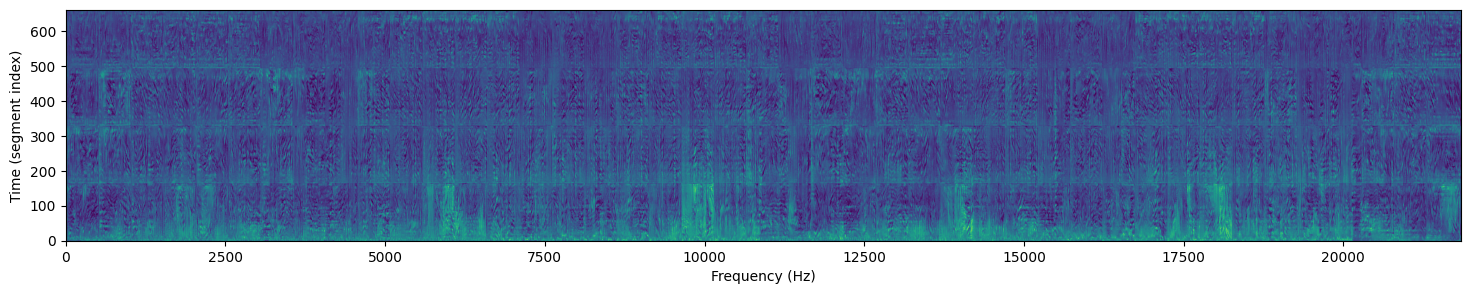

In [23]:
# read the image as a numpy array
img_float64 = np.asarray(image[:,:,2]).astype("float64")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_1", signal_name = "ORIGINAL")

# return the original values
img_reconstructed_R = ((freq_max - freq_min) * img_float64) + freq_min

# Display the frequency domain image
plot_freq_array(img_reconstructed_R.T)

The image below has a dimension of:  (662, 21837)


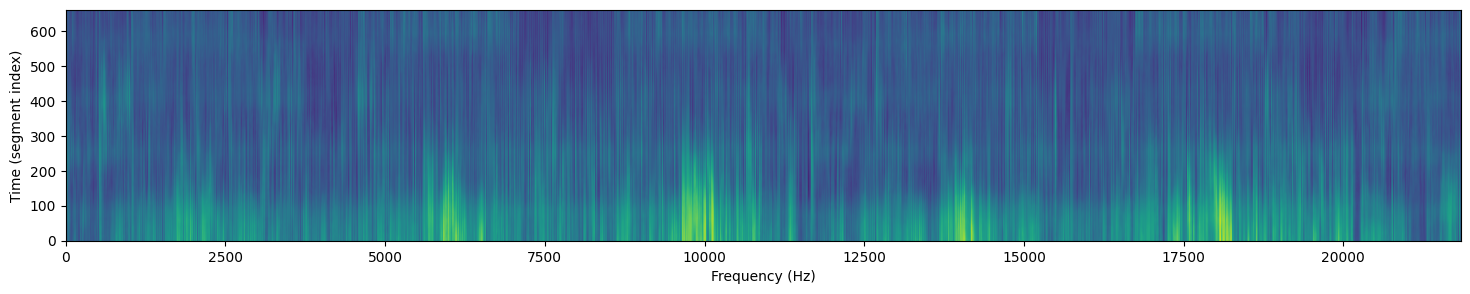

In [24]:
# read the image as a numpy array
img_float64 = np.asarray(blurred_image_2[:,:,2]).astype("float64")

# normalize the array to the range [0,1]
img_float64 = (img_float64) / 255.0

freq_max, freq_min = read_max_min(dir_name_input = "OUTPUT_1", signal_name = "ORIGINAL")

# return the original values
img_reconstructed_blurred_R = ((freq_max - freq_min) * img_float64) + freq_min

# Display the frequency domain image
plot_freq_array(img_reconstructed_blurred_R.T)

## Freq ARRAY TO AUDIO

Now we want to transform the frequency domain representation into a time domain representation. That is, we are going to apply the IDCT. 

To do this, we will first load the following elements:
* The matrix of signs.
* The sample rate of the original song.
* The number of samples we used.
* The length of each segment.

In [25]:
mat_signs = np.load(join("OUTPUT_1", "ORIGINAL_mat_signs.npy"))
sample_rate = np.loadtxt(join("OUTPUT_1", "ORIGINAL_sample_rate.txt"), dtype=int)
n_samples = np.loadtxt(join("OUTPUT_1", "ORIGINAL_n_samples.txt"), dtype=int)
segment_length = np.loadtxt(join("OUTPUT_1", "ORIGINAL_segment_length.txt"), dtype=int)

Then we'll define the function that will apply the IDCT as well as an auxiliar function that will help in that process.

In [26]:
def obtain_dct_segments(freq_array, mat_signs):
    return (np.exp(freq_array) - 1) * mat_signs

In [27]:
def write_reconstructed_signal(freq_array, mat_signs, segment_length, sample_rate, n_samples, output_dir_name = "OUTPUT", file_name = "RECONSTRUCTED_FROM_ORIGINAL_IMAGE"):
    # Inverse the process to reconstruct the original signal
    reconstructed_signal = np.zeros(n_samples)

    dct_segments = obtain_dct_segments(freq_array, mat_signs)

    for i, segment in enumerate(dct_segments):
        segment_signal = sp.idct(segment, type=2, norm='ortho')
        reconstructed_signal[i * segment_length : i * segment_length + segment_length] += segment_signal

    # Normalize the reconstructed signal to [-1, 1] range
    reconstructed_signal = reconstructed_signal / np.max(np.abs(reconstructed_signal))

    # Scale the signal back to the original 16-bit range
    reconstructed_signal = np.int16(reconstructed_signal * (2**15))
    
    # Write the reconstructed signal to a new .wav file
    write_wav(file_name, sr = sample_rate, signal = reconstructed_signal, output_dir_name = output_dir_name)

At this point we have all the necesary ingredients to reconstruct the audios by applying the IDCT.

## Audio Reconstructions

Now we simply apply the IDCT to each image we want to analyze.

In [28]:
# GREY
reconstructed_signal_GREY = write_reconstructed_signal(img_reconstructed_GREY.T, mat_signs, segment_length, sample_rate, n_samples, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY", output_dir_name = "OUTPUT_3")
reconstructed_signal_blurred_GREY = write_reconstructed_signal(img_reconstructed_blurred_GREY.T, mat_signs, segment_length, sample_rate, n_samples, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_GREY", output_dir_name = "OUTPUT_3")
reconstructed_signal_blurred_2_GREY = write_reconstructed_signal(img_reconstructed_blurred_2_GREY.T, mat_signs, segment_length, sample_rate, n_samples, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_2_GREY", output_dir_name = "OUTPUT_3")

# BLUE
reconstructed_signal_B = write_reconstructed_signal(img_reconstructed_B.T, mat_signs, segment_length, sample_rate, n_samples, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_B", output_dir_name = "OUTPUT_3")
reconstructed_signal_blurred_B = write_reconstructed_signal(img_reconstructed_blurred_B.T, mat_signs, segment_length, sample_rate, n_samples, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_B", output_dir_name = "OUTPUT_3")

# GREEN
reconstructed_signal_G = write_reconstructed_signal(img_reconstructed_G.T, mat_signs, segment_length, sample_rate, n_samples, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_G", output_dir_name = "OUTPUT_3")
reconstructed_signal_blurred_G = write_reconstructed_signal(img_reconstructed_blurred_G.T, mat_signs, segment_length, sample_rate, n_samples, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_G", output_dir_name = "OUTPUT_3")

# RED
reconstructed_signal_R = write_reconstructed_signal(img_reconstructed_R.T, mat_signs, segment_length, sample_rate, n_samples, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_R", output_dir_name = "OUTPUT_3")
reconstructed_signal_blurred_R = write_reconstructed_signal(img_reconstructed_blurred_R.T, mat_signs, segment_length, sample_rate, n_samples, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_R", output_dir_name = "OUTPUT_3")

And we can observe the generated audios:

## GREY

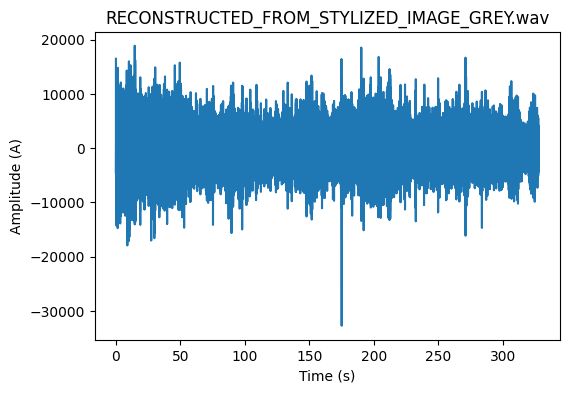

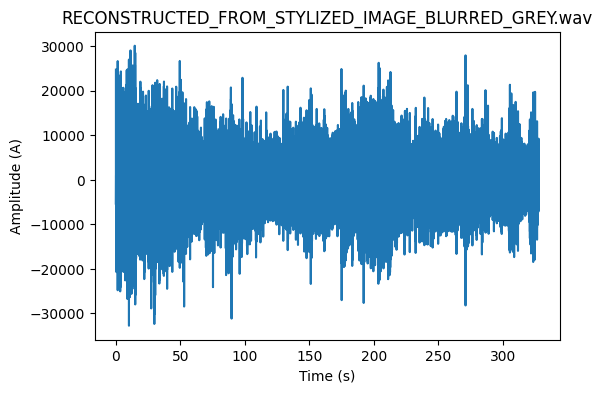

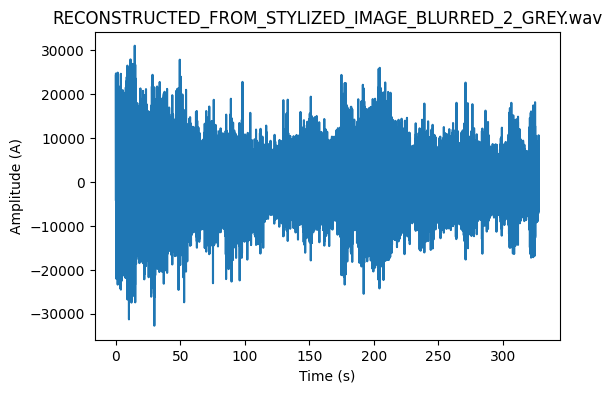

In [29]:
sample_rate_GREY, reconstructed_signal_GREY = read_wav(file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY", dir_name_input = "OUTPUT_3")
plot_signal(sample_rate_GREY, reconstructed_signal_GREY, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_GREY", file_suffix = "wav")

sample_rate_blurred_GREY, reconstructed_signal_blurred_GREY = read_wav(file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_GREY", dir_name_input = "OUTPUT_3")
plot_signal(sample_rate_blurred_GREY, reconstructed_signal_blurred_GREY, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_GREY", file_suffix = "wav")

sample_rate_blurred_2_GREY, reconstructed_signal_blurred_2_GREY = read_wav(file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_2_GREY", dir_name_input = "OUTPUT_3")
plot_signal(sample_rate_blurred_2_GREY, reconstructed_signal_blurred_2_GREY, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_2_GREY", file_suffix = "wav")

## BLUE

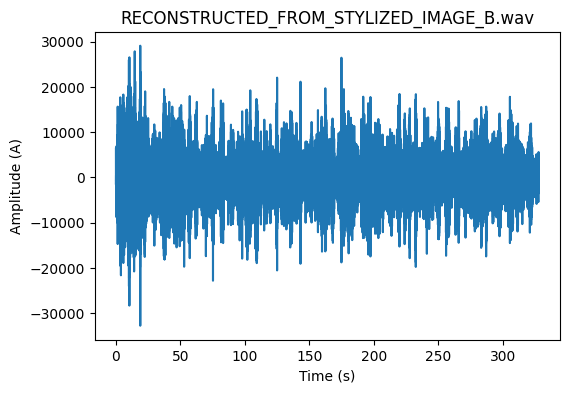

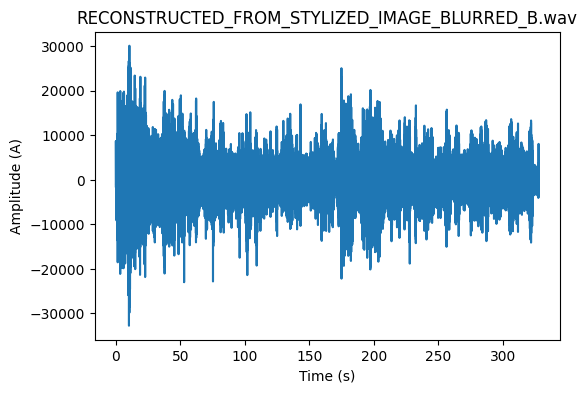

In [30]:
sample_rate_B, reconstructed_signal_B = read_wav(file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_B", dir_name_input = "OUTPUT_3")
plot_signal(sample_rate_B, reconstructed_signal_B, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_B", file_suffix = "wav")

sample_rate_blurred_B, reconstructed_signal_blurred_B = read_wav(file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_B", dir_name_input = "OUTPUT_3")
plot_signal(sample_rate_blurred_B, reconstructed_signal_blurred_B, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_B", file_suffix = "wav")

## GREEN

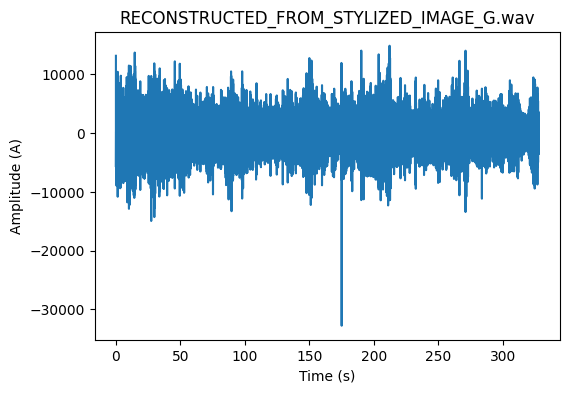

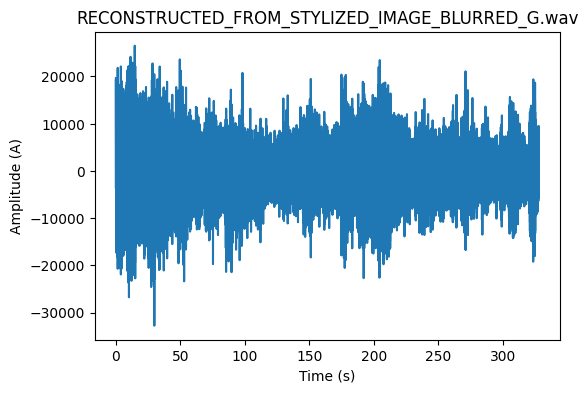

In [31]:
sample_rate_G, reconstructed_signal_G = read_wav(file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_G", dir_name_input = "OUTPUT_3")
plot_signal(sample_rate_G, reconstructed_signal_G, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_G", file_suffix = "wav")

sample_rate_blurred_G, reconstructed_signal_blurred_G = read_wav(file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_G", dir_name_input = "OUTPUT_3")
plot_signal(sample_rate_blurred_G, reconstructed_signal_blurred_G, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_G", file_suffix = "wav")

## RED

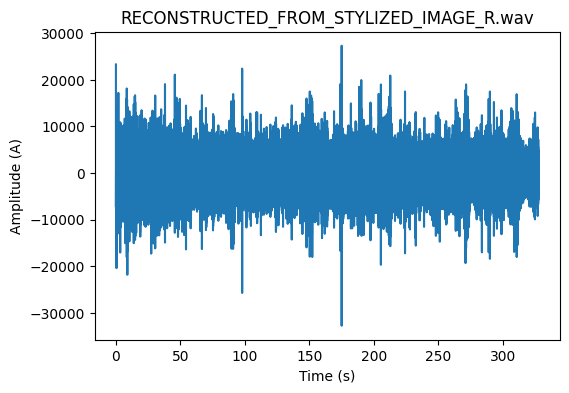

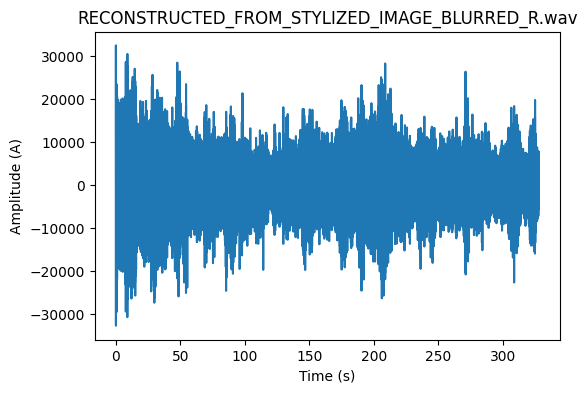

In [32]:
sample_rate_R, reconstructed_signal_R = read_wav(file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_R", dir_name_input = "OUTPUT_3")
plot_signal(sample_rate_R, reconstructed_signal_R, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_R", file_suffix = "wav")

sample_rate_blurred_R, reconstructed_signal_blurred_R = read_wav(file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_R", dir_name_input = "OUTPUT_3")
plot_signal(sample_rate_blurred_R, reconstructed_signal_blurred_R, file_name = "RECONSTRUCTED_FROM_STYLIZED_IMAGE_BLURRED_R", file_suffix = "wav")